## Analisis de Sentimiento


El objetivo de este apartado es poder calcular un puntaje a la columna review en función del sentimiento de cada comentario (review) del usuario, ya sea este positivo, negativo o neutral.
Previamente a este análisis se aplica una función que a su vez aplica stemming, lemmatiización o remoción de stopwords, si así se desea.

In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
import string
import matplotlib.pyplot as plt
import seaborn as sns



**Carga de Datos**

In [2]:
# Carga de base de datos de reviews
df_reviews= pd.read_parquet(r'C:\Users\Lenovo\Desktop\Proyecto Individual\Datasets\0. Data\Reviews.parquet')

*Revisamos nuestra base de datos para saber si hay algo más que ajustar en nuestra columna review*

In [3]:
df_reviews.sample(10)

,user_id,posted,item_id,recommend,review
14115,soupstore,"Posted December 21, 2014.",4000,True,Great game for pretty much anyone but especial...
34695,76561198086118981,"Posted December 27, 2013.",1250,True,kak
49018,76561198059330972,"Posted January 28, 2015.",248170,True,Great it really helped me make my fnaf fan gam...
21876,76561198105170325,"Posted December 4, 2014.",570,True,a
20848,zeshirky,Posted July 22.,4000,True,The game that gave me endless fun years ago I...
51499,drake7758,"Posted March 14, 2014.",4000,True,This game is soooooo AWESOME XD
15264,jerrygetajob,"Posted April 21, 2015.",271590,True,Like gta without Roman
7245,Uve-Seen_Nothing,"Posted July 19, 2015.",291210,False,The last time i saw this game it was a bloody ...
17000,76561198028390064,"Posted December 12, 2014.",730,True,Pew pew shooty shooty
29888,76561198070506735,Posted May 24.,301520,False,RC Was a good game untill i accedently meged m...


In [4]:
# se realiza una copia antes de iniciar 
df_copy= df_reviews.copy()
df_copy

,user_id,posted,item_id,recommend,review
0,76561197970982479,"Posted November 5, 2011.",1250,True,Simple yet with great replayability In my opin...
1,76561197970982479,"Posted July 15, 2011.",22200,True,Its unique and worth a playthrough
2,76561197970982479,"Posted April 21, 2011.",43110,True,Great atmosphere The gunplay can be a bit chun...
3,js41637,"Posted June 24, 2014.",251610,True,I know what you think when you see this title ...
4,js41637,"Posted September 8, 2013.",227300,True,For a simple its actually not all that simple ...
...,...,...,...,...,...
58396,76561198312638244,Posted July 10.,70,True,a must have classic from steam definitely wort...
58397,76561198312638244,Posted July 8.,362890,True,this game is a perfect remake of the original ...
58398,LydiaMorley,Posted July 3.,273110,True,had so much fun plaing this and collecting res...
58399,LydiaMorley,Posted July 20.,730,True,D


**Chequeamos valores faltantes**

In [5]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58401 entries, 0 to 58400
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user_id    58401 non-null  object
 1   posted     58401 non-null  object
 2   item_id    58401 non-null  int64 
 3   recommend  58401 non-null  bool  
 4   review     58401 non-null  object
dtypes: bool(1), int64(1), object(3)
memory usage: 1.8+ MB


In [6]:
# Nos aseguramos que columna review y recommend sean del tipo string
df_copy['review'] = df_copy['review'].astype(str)
df_copy['recommend'] = df_copy['recommend'].astype(bool)

In [7]:
# Revisamos que no existan celdas vacías
nulos = df_copy[df_copy['review'] == '']
nulos

,user_id,posted,item_id,recommend,review
67,76561198070565427,"Posted October 17, 2014.",242700,True,
69,76561198070565427,"Posted April 28, 2014.",224260,True,
83,boydeer,"Posted May 12, 2014.",440,True,
84,boydeer,"Posted August 24, 2015.",383080,False,
147,76561198056741844,"Posted October 14, 2014.",730,True,
...,...,...,...,...,...
58274,huangsy,Posted June 11.,304930,True,
58308,76561198209894493,Posted February 24.,387990,True,
58327,76561198227671916,Posted April 11.,427520,True,
58344,AusBacon,Posted March 17.,369290,False,


In [8]:
# Reemplazar las cadenas vacías y otros posibles valores como 'None', 'N/A', 'NA' a valores nulos
df_copy = df_copy.replace(['', 'None', 'N/A', 'NA'], np.nan)

In [9]:
df_reviews.isnull().sum()

user_id      0
posted       0
item_id      0
recommend    0
review       0
dtype: int64

In [10]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58401 entries, 0 to 58400
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user_id    58401 non-null  object
 1   posted     58401 non-null  object
 2   item_id    58401 non-null  int64 
 3   recommend  58401 non-null  bool  
 4   review     58401 non-null  object
dtypes: bool(1), int64(1), object(3)
memory usage: 1.8+ MB


*Inicializamos los procesos analizador de intensidad de sentimiento, el stemmer y el lematizador, creando una instancia para cada uno de ellos*

In [11]:
# Inicializar el analizador de intensidad de sentimiento de NLTK
sid = SentimentIntensityAnalyzer()

# Inicializar el stemmer
stemmer = PorterStemmer()

# Inicializar el lematizador
lemmatizer = WordNetLemmatizer()  

In [12]:
# Se advierten textos en otros idiomas, se inicializan listas de stopwords en inglés, español y portugués
stop_words_en = set(stopwords.words('english'))
stop_words_es = set(stopwords.words('spanish'))
stop_words_pt = set(stopwords.words('portuguese'))

# Unir las stopwords de los tres idiomas en un solo conjunto
all_stop_words = stop_words_en.union(stop_words_es).union(stop_words_pt)

# Se crea una función para procesar el texto y hacer todas las transformaciones
def preprocess_text(text, apply_stemming=True, apply_lemmatization=True, remove_stopwords=True):

    # Función para preprocesar el texto y aplicar stemming, lemmatización o remoción de stopwords de forma optativa.

    if pd.isna(text):  # Verificar si el texto es nulo
        return text
    
    # Convertir a minúsculas
    text = text.lower()
    
    # Eliminar signos de puntuación
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Tokenizar el texto
    words = word_tokenize(text)
    
    # Eliminar stopwords si es necesario
    if remove_stopwords:
        words = [word for word in words if word not in all_stop_words]
    
    # Aplicar stemming si es necesario
    if apply_stemming:
        words = [stemmer.stem(word) for word in words]
    
    # Aplicar lematización si es necesario
    if apply_lemmatization:
        words = [lemmatizer.lemmatize(word) for word in words]
    
    # Unir las palabras procesadas
    return ' '.join(words)

# Se aplica la función de preprocesamiento a la columna 'review' del DataFrame
df_copy['review'] = df_copy['review'].apply(preprocess_text)


Se crea una función para calcular el score del sentimiento y se aplica a la columna 'review' de dataframe 

In [13]:

# Se aplica la función get_sentiment, para obtener los scores
def get_sentiment(text, recommend):
    if pd.isnull(text):
        return 1  # Neutral en caso de que el texto sea nulo

    # Calcular el puntaje de sentimiento compuesto
    sentiment_score = sid.polarity_scores(text)['compound']
    
    # Ajustar el puntaje según la recomendación
    if recommend:
        sentiment_score += 0.5
    else:
        sentiment_score -= 0.5
    
    # Clasificar el sentimiento
    if sentiment_score <= -0.05:
        return 0
    elif sentiment_score >= 0.05:
        return 2
    else:
        return 1

# Aplicar la función get_sentiment al DataFrame para crear la nueva columna 'sentiment_analysis'
df_copy['sentiment_analysis'] = df_copy.apply(lambda row: get_sentiment(row['review'], row['recommend']), axis=1)


*Revisamos el resultado del análisis*

In [14]:
df_copy.sample(10)

,user_id,posted,item_id,recommend,review,sentiment_analysis
5304,76561198054564148,"Posted January 27, 2014.",33230,True,best charact awesom mission best stori ac bett...,2
3539,lNightlRaven,"Posted February 8, 2015.",9900,True,fun game play long time lvled sever characht h...,2
32318,supfoo3,"Posted July 24, 2014.",8600,False,freakin trerribl overdramaticov sensit crashes...,2
14993,obeseninja27,Posted March 18.,218620,False,want give game date review year ago wrote revi...,2
22983,76561198038263531,"Posted April 26, 2015.",238960,True,NaN,1
46945,Tyrranis,"Posted December 27, 2011.",55150,True,nice meati game viscer combat within reason co...,2
4637,76561198067777635,"Posted September 3, 2015.",232090,True,im tri heal shank,2
42623,cretanarcher,"Posted December 19, 2012.",56400,True,awesom xd,2
28826,EnvyMan35,"Posted April 25, 2015.",218680,True,scribblenaut unlimit game nice happi graphic m...,2
14265,76561198119335225,Posted July 24.,238460,True,omg yessssssss,2


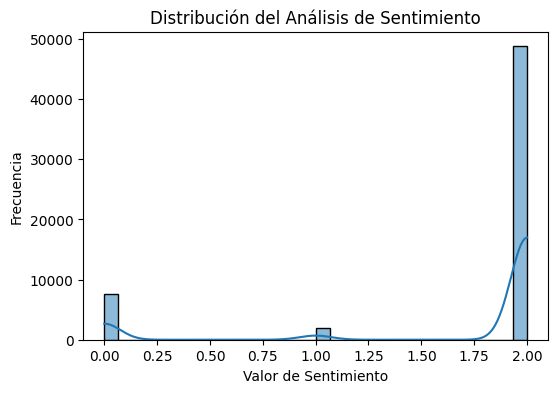

In [15]:
# Graficamos la distribución del análisis de sentimiento
plt.figure(figsize=(6, 4))
sns.histplot(df_copy['sentiment_analysis'], bins=30, kde=True)
plt.title('Distribución del Análisis de Sentimiento')
plt.xlabel('Valor de Sentimiento')
plt.ylabel('Frecuencia')
plt.show()

*Revisamos el resultado de nuestro análisis y calculamos la tasa de errores*

In [16]:
# Reseñas con sentimiento positivo pero con una recomendación negativa.
positive_negative = df_copy[(df_copy['sentiment_analysis'] == 2) & (df_copy['recommend'] == False)]
count_positive_negative = len(positive_negative)

# Reseñas con sentimiento negativo pero con una recomendación positiva.
negative_positive = df_copy[(df_copy['sentiment_analysis'] == 0) & (df_copy['recommend'] == True)]
count_negative_positive = len(negative_positive)

print("Reviews con sentimiento positivo y recomendación negativa:", count_positive_negative)
print("Reviews con sentimiento positivo y recomendación negativa:", count_negative_positive)

mistakes = count_negative_positive + count_positive_negative
records= 58401
mistakes_rate= mistakes/records

print(f'la tasa de errores del análisis de sentimiento es', mistakes_rate)

Reviews con sentimiento positivo y recomendación negativa: 1428
Reviews con sentimiento positivo y recomendación negativa: 2666
la tasa de errores del análisis de sentimiento es 0.07010153935720279


*Finalmente, guardamos este nuevo dataset en formato parquet*

In [17]:
df_copy.to_parquet('Reviews_sent_analysis.parquet', index=False)